# Real Bogus Experiment

We used two subtraction techniques

Zackay's and Bramich's DIA algorithms.
Both were applied on the same new--ref pair of images and the same source identification algorithm.
Both dataset are comparable... 

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_context(font_scale=1.2)

In [3]:
from sqlalchemy import create_engine
import pandas as pd

In [4]:
import os
plot_dir = os.path.abspath('./plots/.')
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

In [5]:
engine = create_engine('sqlite:///../RBpipeline/rbogus-dev.db')

Asking to the database for the undetected objects (False Negatives)

In [6]:
simulated = pd.read_sql_query("""SELECT * FROM Simulated""", engine)

In [7]:
und_z = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, S.r_scales, S.gx_mag, U.simulated_id 
                             FROM Simulated S INNER JOIN Undetected U
                             ON S.id==U.simulated_id""", 
                          engine)

In [8]:
und_b = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, S.r_scales, S.gx_mag, U.simulated_id 
                             FROM Simulated S INNER JOIN UndetectedOIS U
                             ON S.id==U.simulated_id""", 
                          engine)

Querying the database to obtain the tables related to the detections.

In [9]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id,
                                        Simulated.r_scales as r_scales,
                                        Simulated.gx_mag as gx_mag 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id,
                                        Simulated.r_scales as r_scales,
                                        Simulated.gx_mag as gx_mag  
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [10]:
# dt_ois.IS_REAL = dt_ois.IS_REAL.astype(int)
# dt_zps.IS_REAL = dt_zps.IS_REAL.astype(int)

### Some plots of simulated objects

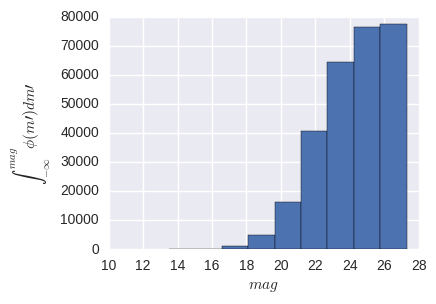

In [11]:
plt.figure(figsize=(4,3))
plt.hist(simulated['app_mag'], cumulative=True)
plt.xlabel(r'$mag$')
plt.ylabel(r'$\int_{-\infty}^{mag}\phi(m\prime)dm\prime$')
plt.savefig(os.path.join(plot_dir, 'lum_fun_simulated.png'), dpi=700)

### Analyzing the fraction of type of objects for each dataset

In [12]:
ois = [sum(dt_ois.IS_REAL), len(und_b), len(dt_ois.IS_REAL)-sum(dt_ois.IS_REAL)]
zps = [sum(dt_zps.IS_REAL), len(und_z), len(dt_zps.IS_REAL)-sum(dt_zps.IS_REAL)]
df2 = pd.DataFrame([zps, ois], columns=['Real', 'False Neg', 'Bogus'])

In [13]:
print df2

    Real  False Neg  Bogus
0  28015      49379   8248
1  36029      41365  47481


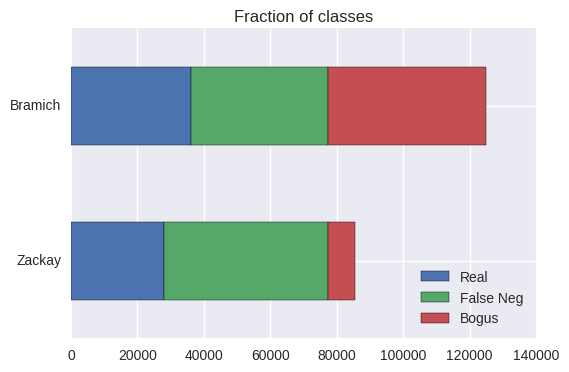

In [14]:
plt.figure(figsize=(4, 3))
df2.plot.barh(stacked=True)
plt.title('Fraction of classes')
plt.xscale('linear')
plt.xlim(0, 140000)
plt.yticks([0,1], ['Zackay', 'Bramich'])

plt.legend(loc='lower right')
plt.savefig(os.path.join(plot_dir, 'fractions_classes.svg'), dpi=700)

## Magnitude offset

We need to calculate the magnitude offset to understand how to compare perfomances.

In [15]:
cx_zps = pd.read_sql_query(
"""SELECT 
  Detected.MAG_ISO, 
  Detected.MAG_AUTO, 
  Detected.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM Detected
  INNER JOIN Reals
    ON Detected.id==Reals.detected_id
  INNER JOIN Simulated
    ON Simulated.id==Reals.simulated_id""", engine)

In [16]:
cx_ois = pd.read_sql_query(
"""SELECT 
  DetectedOIS.MAG_ISO,
  DetectedOIS.MAG_AUTO,
  DetectedOIS.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM DetectedOIS
  INNER JOIN RealsOIS
    ON DetectedOIS.id==RealsOIS.detected_id
  INNER JOIN Simulated
    ON Simulated.id==RealsOIS.simulated_id""", engine)

In [17]:
detections = pd.merge(cx_ois, cx_zps, on='sim_id', suffixes=('_ois','_zps'))

In [18]:
detections['MAG_OFFSET_zps'] = detections['sim_mag_zps'] - detections['MAG_ISO_zps']
detections['MAG_OFFSET_ois'] = detections['sim_mag_ois'] - detections['MAG_ISO_ois']

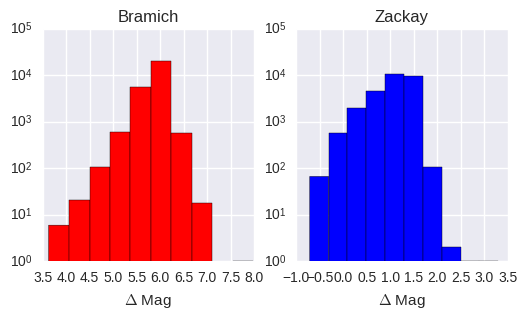

In [19]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.hist(detections['MAG_OFFSET_ois'], log=True, color='red')
plt.title('Bramich')
plt.xlabel(r'$\Delta$ Mag')
plt.subplot(122)
plt.hist(detections['MAG_OFFSET_zps'], log=True, color='blue')
plt.xlabel(r'$\Delta$ Mag')
plt.title('Zackay')
#plt.show()

plt.savefig(os.path.join(plot_dir, 'mag_offset.png'), format='png', dpi=700)

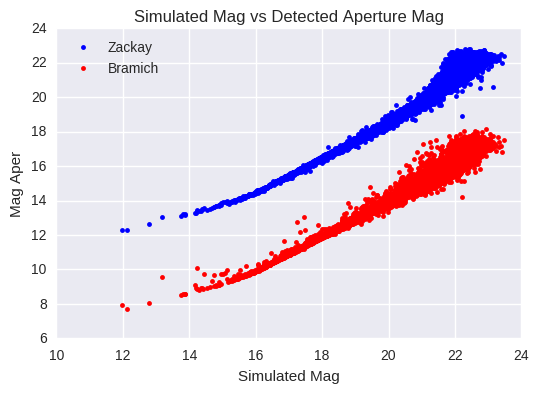

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(detections['sim_mag_zps'], detections['MAG_ISO_zps'], 'b.', label='Zackay')
plt.plot(detections['sim_mag_ois'], detections['MAG_ISO_ois'], 'r.', label='Bramich')
plt.ylabel('Mag Aper')
plt.xlabel('Simulated Mag')
plt.title('Simulated Mag vs Detected Aperture Mag')
plt.legend(loc='best')
plt.savefig(os.path.join(plot_dir, 'aper_vs_simulated_mag.png'), format='png', dpi=700)

In [21]:
print 'Mean magniutde difference for Zackay is {}'.format(detections.MAG_OFFSET_zps.mean())
print 'Mean magniutde difference for Bramich is {}'.format(detections.MAG_OFFSET_ois.mean())

Mean magniutde difference for Zackay is 1.07647872623
Mean magniutde difference for Bramich is 5.91896277052


In [22]:
dt_ois['mag'] = dt_ois['MAG_ISO'] + detections.MAG_OFFSET_ois.mean()
dt_zps['mag'] = dt_zps['MAG_ISO'] + detections.MAG_OFFSET_zps.mean()

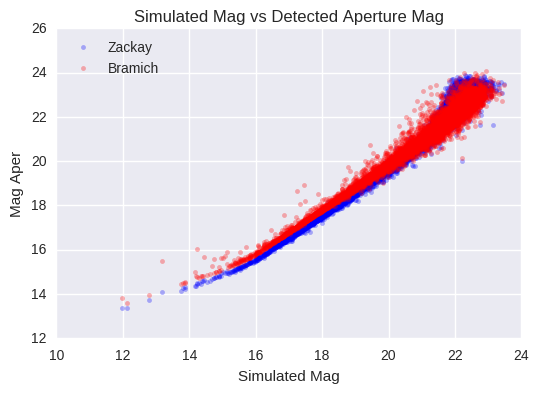

In [23]:
plt.plot(detections['sim_mag_zps'], 
         detections['MAG_ISO_zps'] + detections.MAG_OFFSET_zps.mean(),
         'b.', label='Zackay', alpha=0.3)
plt.plot(detections['sim_mag_ois'],
         detections['MAG_ISO_ois'] + detections.MAG_OFFSET_ois.mean(),
         'r.', label='Bramich', alpha=0.3)
plt.ylabel('Mag Aper')
plt.xlabel('Simulated Mag')
plt.title('Simulated Mag vs Detected Aperture Mag')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'corrected_aper_vs_simulated_mag.png'), format='png', dpi=900)

In [24]:
dt_ois['mu'] = dt_ois.mag/(dt_ois.A_IMAGE*dt_ois.B_IMAGE)
dt_zps['mu'] = dt_zps.mag/(dt_zps.A_IMAGE*dt_zps.B_IMAGE)

In [25]:
bogus_b = dt_ois[dt_ois.IS_REAL==False]
reals_b = dt_ois[dt_ois.IS_REAL==True]

bogus_z = dt_zps[dt_zps.IS_REAL==False]
reals_z = dt_zps[dt_zps.IS_REAL==True]

## Luminosity function 

Bogus, Real, and FN luminosity functions.


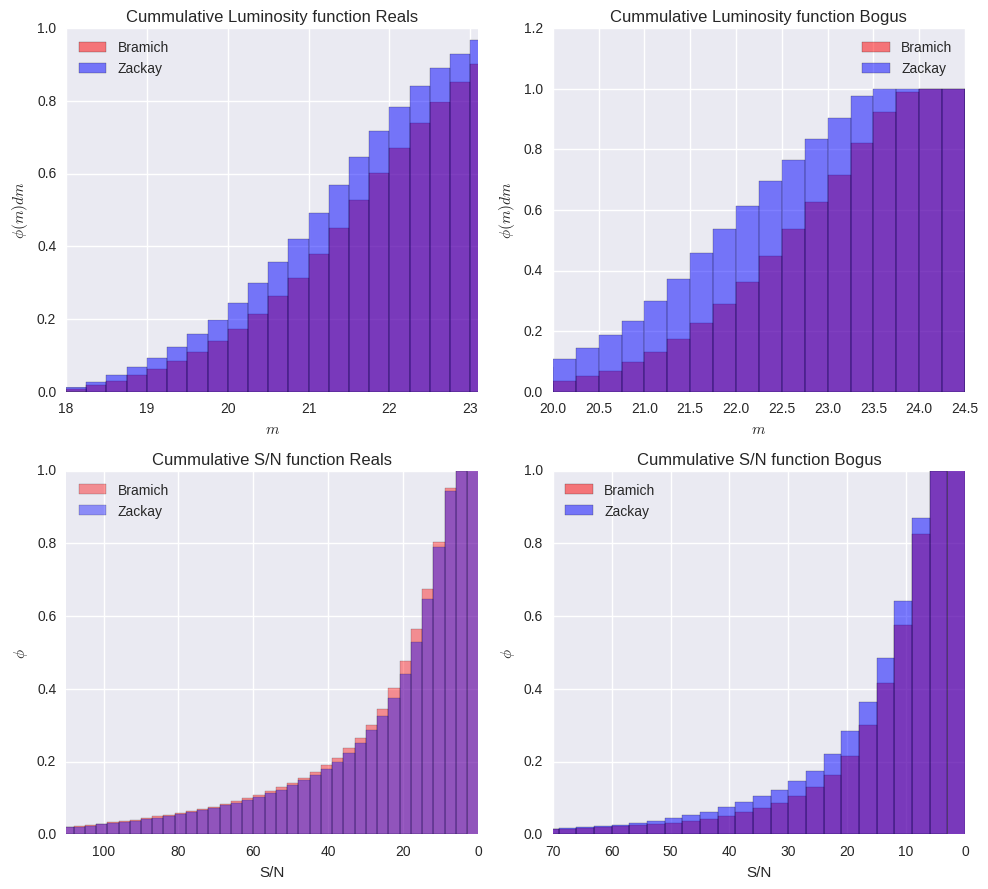

In [26]:
plt.figure(figsize=(10,9))

#magnitude bins
bins = np.arange(18, 25, 0.25)

plt.subplot(221)
plt.hist(reals_b.mag, alpha=0.5, bins=bins, normed=True, #shade=True, 
            cumulative=True, label='Bramich', color='red')
plt.hist(reals_z.mag, alpha=0.5, bins=bins, normed=True, #shade=True, 
            cumulative=True, label='Zackay', color='blue')

plt.xlim(18, 23.1)
plt.title('Cummulative Luminosity function Reals')
plt.ylabel(r'$\phi(m)dm$')
plt.legend(loc='best')
plt.xlabel(r'$m$')

plt.subplot(222)
plt.hist(bogus_b.mag, alpha=0.5, bins=bins, normed=True, #shade=True, 
            cumulative=True, label='Bramich', color='red')
plt.hist(bogus_z.mag, alpha=0.5, bins=bins, normed=True, #shade=True, 
            cumulative=True, label='Zackay', color='blue')

plt.xlim(20, 24.5)
plt.ylabel(r'$\phi(m)dm$')
plt.legend(loc='best')
plt.xlabel(r'$m$')
plt.title('Cummulative Luminosity function Bogus')

#signal to noise bins
bins = np.arange(0, 140, 3)

plt.subplot(223)
plt.hist(reals_b.FLUX_ISO/reals_b.FLUXERR_ISO,  bins=bins, normed=True, #shade=True, 
            label='Bramich', color='red', cumulative=-1, alpha=0.4)
plt.hist(reals_z.FLUX_ISO/reals_z.FLUXERR_ISO,  bins=bins, normed=True, #shade=True, 
         label='Zackay', color='blue', cumulative=-1, alpha=0.4)

plt.xlim(110, 0)
plt.title('Cummulative S/N function Reals')
plt.legend(loc='best')
plt.ylabel(r'$\phi$')
plt.xlabel('S/N')

plt.subplot(224)
plt.hist(bogus_b.FLUX_ISO/bogus_b.FLUXERR_ISO, bins=bins, normed=True, #shade=True, 
         label='Bramich', color='red', cumulative=-1, alpha=0.5)
plt.hist(bogus_z.FLUX_ISO/bogus_z.FLUXERR_ISO, bins=bins, normed=True, #shade=True, 
         label='Zackay', color='blue', cumulative=-1, alpha=0.5)

plt.xlim(70, 0)
plt.title('Cummulative S/N function Bogus')
plt.ylabel(r'$\phi$')
plt.legend(loc='best')
plt.xlabel('S/N')

plt.tight_layout()
#plt.show()

plt.savefig(os.path.join(plot_dir, 'luminosities_functions.png'), format='png', dpi=700)

## What about the FN?

We should check on the lost objects.

### Luminosity function for Undetected

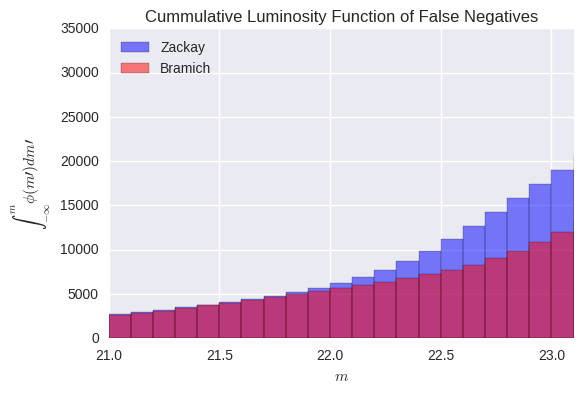

In [27]:
bins = np.arange(18, 24, 0.1)

plt.figure()
# sns.kdeplot(und_z.app_mag, cumulative=True, shade=True, color='blue', label='Zackay')
# sns.kdeplot(und_b.app_mag, cumulative=True, shade=True, color='red', label='Bramich')
plt.hist(und_z.app_mag, cumulative=True, bins=bins,
         #histtype='stepfilled', 
         color='blue', label='Zackay', alpha=0.5)
plt.hist(und_b.app_mag, cumulative=True, bins=bins, 
         #histtype='stepfilled', 
         color='red', label='Bramich', alpha=0.5)


plt.legend(loc='upper left')
plt.ylabel(r'$\int_{-\infty}^{m}\phi(m\prime)dm\prime$')
plt.xlabel(r'$m$')
plt.title('Cummulative Luminosity Function of False Negatives')
plt.xlim(21., 23.1)
#plt.show()

plt.savefig(os.path.join(plot_dir, 'lum_function_FNegatives.png'), format='png', dpi=700)

### Are there coincident objects?

In [28]:
und_b.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'r_scales', u'gx_mag',
       u'simulated_id'],
      dtype='object')

In [29]:
und_z.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'r_scales', u'gx_mag',
       u'simulated_id'],
      dtype='object')

In [30]:
und_mix = pd.merge(left=und_b, right=und_z, on='simulated_id', suffixes=('_b', '_z'), how='outer', indicator='row_from')

In [31]:
und_mix.columns

Index([         u'x_b',          u'y_b',    u'app_mag_b',   u'image_id_b',
         u'r_scales_b',     u'gx_mag_b', u'simulated_id',          u'x_z',
                u'y_z',    u'app_mag_z',   u'image_id_z',   u'r_scales_z',
           u'gx_mag_z',     u'row_from'],
      dtype='object')

In [32]:
magnitudes_und = pd.DataFrame({'mag_both' : und_mix[und_mix.row_from=='both'].app_mag_b,
                               'mag_onlyb': und_mix[und_mix.row_from=='left_only'].app_mag_b,
                               'mag_onlyz': und_mix[und_mix.row_from=='right_only'].app_mag_z})

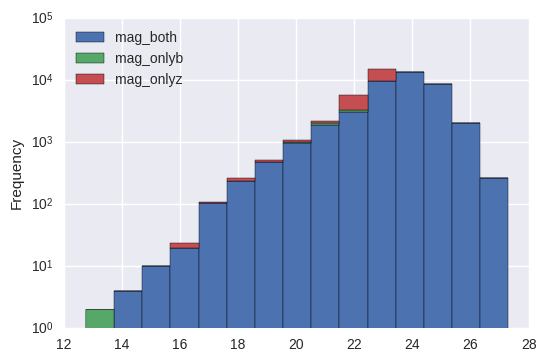

In [33]:
magnitudes_und.plot.hist(stacked=True, bins=15, log=True)

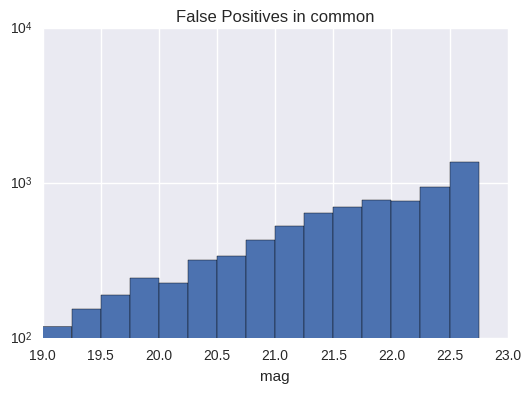

In [34]:
bins = np.arange(19, 23., 0.25)
plt.hist(und_mix.app_mag_b[und_mix.row_from=='both'], bins=bins, log=True)
plt.title('False Positives in common')
plt.xlabel('mag')
plt.xlim(19, 23.)
plt.show()

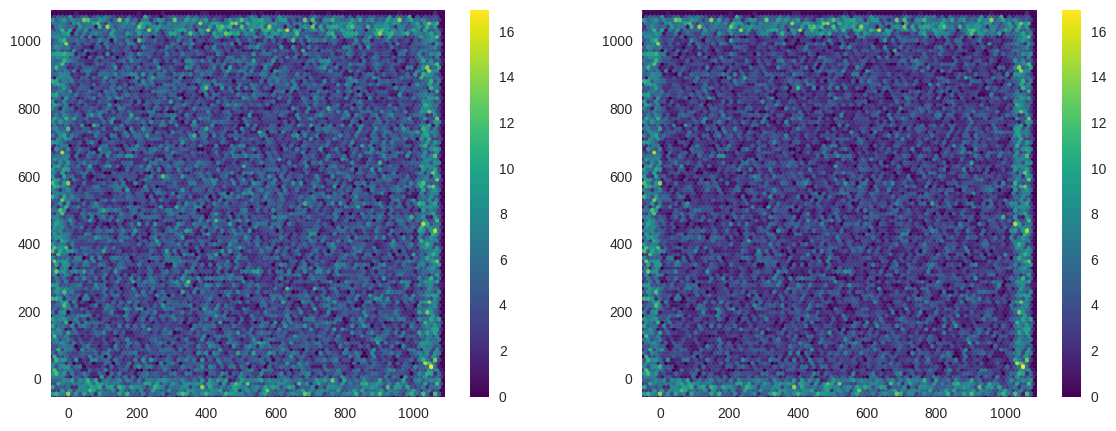

In [35]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.xlabel
plt.hexbin(und_z.x, und_z.y, cmap='viridis')
plt.colorbar()
plt.subplot(122)
plt.hexbin(und_b.x, und_b.y, cmap='viridis')
plt.colorbar()

/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in log10


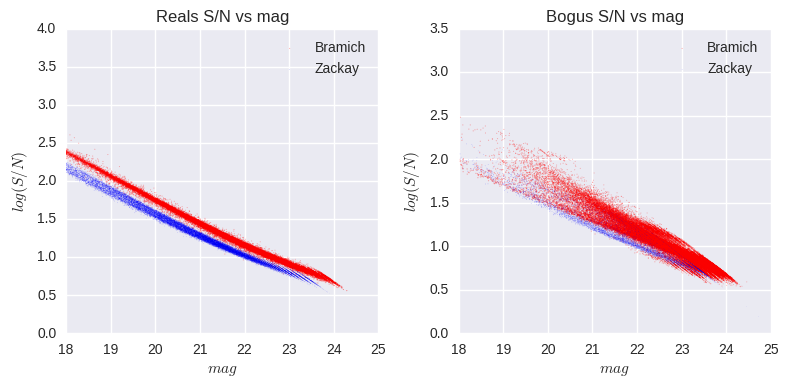

In [36]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals S/N vs mag')
plt.scatter(reals_b.mag, 
         np.log10(reals_b.FLUX_ISO/reals_b.FLUXERR_ISO),
         s=np.log10(reals_b.FLUXERR_ISO), linewidths=0.001, 
        c='r', marker='.', alpha=0.3, label='Bramich')
plt.scatter(reals_z.mag, 
         np.log10(reals_z.FLUX_ISO/reals_z.FLUXERR_ISO), 
         s=np.log10(reals_z.FLUXERR_ISO), linewidths=0.001,
         c='b', marker='.', alpha=0.3, label='Zackay')
plt.xlim(18,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.subplot(122)
plt.title('Bogus S/N vs mag')
plt.scatter(bogus_b.mag,
            np.log10(bogus_b.FLUX_ISO/bogus_b.FLUXERR_ISO),
            s=np.log10(bogus_b.FLUXERR_ISO), linewidths=0.001,
            c='r', marker='.', alpha=0.3, label='Bramich') 
plt.scatter(bogus_z.mag,
            np.log10(bogus_z.FLUX_ISO/bogus_z.FLUXERR_ISO),
            s=np.log10(bogus_z.FLUXERR_ISO), linewidths=0.001,
            c='b', marker='.', alpha=0.3, label='Zackay')
plt.xlim(18,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag.png'), format='png', dpi=700)

/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


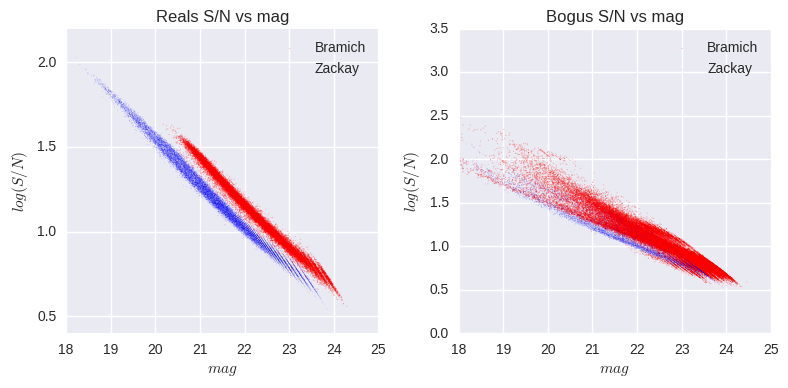

In [37]:
low_cstar_b = reals_b.CLASS_STAR < 0.005
low_cstar_z = reals_z.CLASS_STAR < 0.005

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals S/N vs mag')
plt.scatter(reals_b.mag[low_cstar_b], 
         np.log10(reals_b.FLUX_ISO/reals_b.FLUXERR_ISO)[low_cstar_b],
         s=np.log10(reals_b.FLUXERR_ISO)[low_cstar_b], linewidths=0.001, 
        c='r', marker='.', alpha=0.3, label='Bramich')
plt.scatter(reals_z.mag[low_cstar_z], 
         np.log10(reals_z.FLUX_ISO/reals_z.FLUXERR_ISO)[low_cstar_z], 
         s=np.log10(reals_z.FLUXERR_ISO)[low_cstar_z], linewidths=0.001,
         c='b', marker='.', alpha=0.3, label='Zackay')
plt.xlim(18,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')


plt.subplot(122)
plt.title('Bogus S/N vs mag')
plt.scatter(bogus_b.mag,
            np.log10(bogus_b.FLUX_ISO/bogus_b.FLUXERR_ISO),
            s=np.log10(bogus_b.FLUXERR_ISO), linewidths=0.001,
            c='r', marker='.', alpha=0.3, label='Bramich') 
plt.scatter(bogus_z.mag,
            np.log10(bogus_z.FLUX_ISO/bogus_z.FLUXERR_ISO),
            s=np.log10(bogus_z.FLUXERR_ISO), linewidths=0.001,
            c='b', marker='.', alpha=0.3, label='Zackay')
plt.xlim(18,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag.png'), format='png', dpi=700)

Need to calculate mean and dispersion of log10(S/N) on magnitude bins.

In [38]:
def binning(data, bins, step):
    meanlogsn = []
    stdvlogsn = []
    
    for abin in bins:
        fdata = data[(data.mag < abin + step) * (data.mag >= abin)]
        meanlogsn.append(np.mean(np.log10(fdata.FLUX_ISO/fdata.FLUXERR_ISO)))
        stdvlogsn.append(np.std( np.log10(fdata.FLUX_ISO/fdata.FLUXERR_ISO)))
    return meanlogsn, stdvlogsn

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/pandas/computation/expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


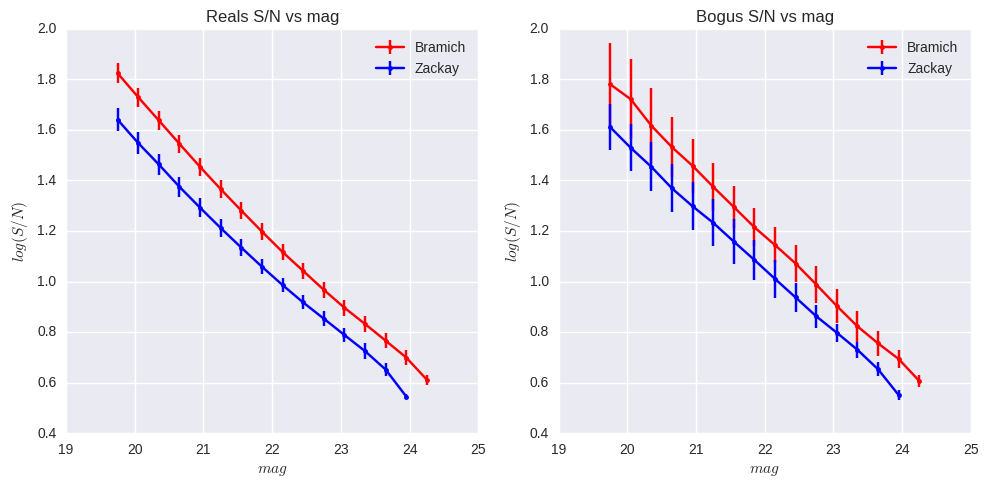

In [39]:
step = 0.3
bins = np.arange(19.6, 24.4, step)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Reals S/N vs mag')
means, stds = binning(reals_b, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001, 
             c='r', marker='.', alpha=1, label='Bramich')

means, stds = binning(reals_z, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             c='b', marker='.', alpha=1, label='Zackay')
plt.xlim(19,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus S/N vs mag')
means, stds = binning(bogus_b, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
            #linewidths=0.001,
            c='r', marker='.', alpha=1, label='Bramich') 
means, stds = binning(bogus_z, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001,
             c='b', marker='.', alpha=1, label='Zackay')
plt.xlim(19,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag_binned.png'), format='png', dpi=700)

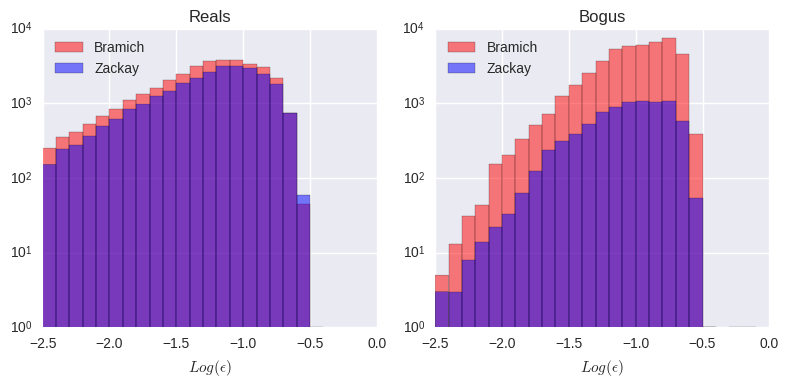

In [40]:
bins=np.arange(-2.5, 0., 0.1)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist(np.log10(reals_b.MAGERR_ISO[reals_b.MAG_ISO < 30]), bins=bins,
         log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(np.log10(reals_z.MAGERR_ISO[reals_z.MAG_ISO < 30]), bins=bins,
         log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'$Log(\epsilon)$')
plt.xlim(-2.5, 0.)
plt.ylim(0, 10000)
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus')
plt.hist(np.log10(bogus_b.MAGERR_ISO[bogus_b.MAG_ISO < 30]), bins=bins,
         log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(np.log10(bogus_z.MAGERR_ISO[bogus_z.MAG_ISO < 30]), bins=bins,
         log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'$Log(\epsilon)$')
plt.xlim(-2.5, 0.)
plt.ylim(0, 10000)
plt.legend(loc='best')

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'mag_errors.png'), format='png', dpi=700)

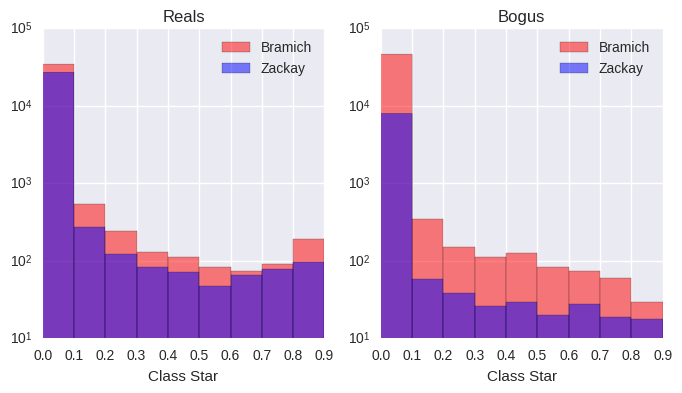

In [41]:
bins = np.arange(0, 1., 0.1)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist(reals_b.CLASS_STAR, log=True, bins=bins, alpha=0.5, color='red', label='Bramich')
plt.hist(reals_z.CLASS_STAR, log=True, bins=bins, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'Class Star')
plt.legend(loc='best')
plt.subplot(122)
plt.title('Bogus')
plt.hist(bogus_b.CLASS_STAR, log=True, bins=bins, alpha=0.5, color='red', label='Bramich')
plt.hist(bogus_z.CLASS_STAR, log=True, bins=bins, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'Class Star')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'class_star_hist.png'), format='png', dpi=700)

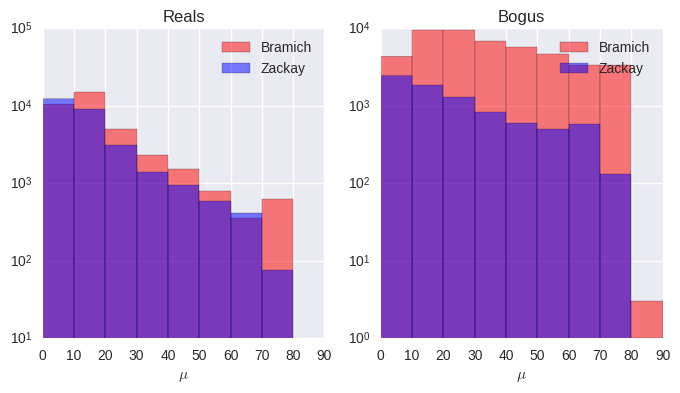

In [42]:
bins = np.arange(0, 100, 10)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist(reals_b.mu, bins=bins, log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(reals_z.mu, bins=bins, log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'$\mu$')
plt.legend(loc='best')
plt.subplot(122)
plt.title('Bogus')
plt.hist(bogus_b.mu, bins=bins, log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(bogus_z.mu, bins=bins, log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'$\mu$')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'mu_hist.png'), format='png', dpi=700)

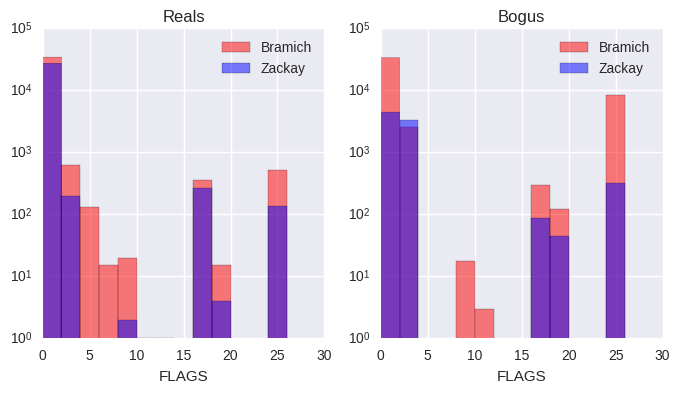

In [43]:
bins = np.arange(0, 28, 2)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist(reals_b.FLAGS, bins=bins, log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(reals_z.FLAGS, bins=bins, log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'FLAGS')
plt.legend(loc='best')
plt.subplot(122)
plt.title('Bogus')
plt.hist(bogus_b.FLAGS, bins=bins, log=True, alpha=0.5, color='red', label='Bramich')
plt.hist(bogus_z.FLAGS, bins=bins, log=True, alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'FLAGS')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'flags_hist.png'), format='png', dpi=700)

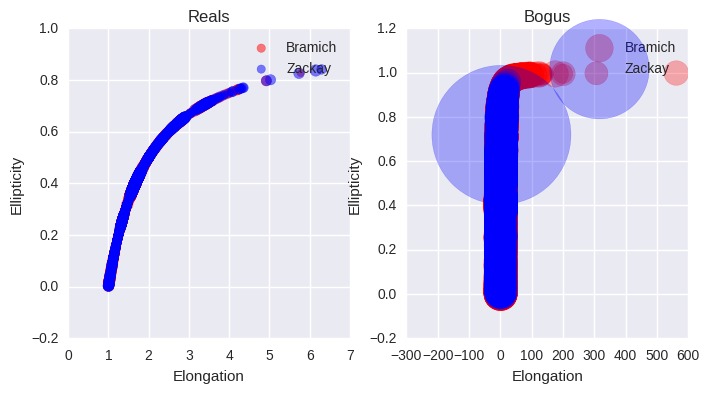

In [44]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.scatter(reals_b.ELONGATION, reals_b.ELLIPTICITY, s=reals_b.mu,
            alpha=0.5, color='red', label='Bramich')
plt.scatter(reals_z.ELONGATION, reals_z.ELLIPTICITY, s=reals_z.mu,
            alpha=0.5, color='blue', label='Zackay')
plt.xlabel(r'Elongation')
plt.ylabel(r'Ellipticity')
plt.legend(loc='best')
# plt.xlim(0, 16)
# plt.ylim(-0.1, 1.3)

plt.subplot(122)
plt.title('Bogus')
plt.scatter(bogus_b.ELONGATION, bogus_b.ELLIPTICITY, s=bogus_b.mag**2,
            alpha=0.3, color='red', label='Bramich')
plt.scatter(bogus_z.ELONGATION, bogus_z.ELLIPTICITY, s=bogus_z.mag**2,
            alpha=0.3, color='blue', label='Zackay')
plt.xlabel(r'Elongation')
plt.ylabel(r'Ellipticity')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'ellipticty_vs_elongation.png'), format='png', dpi=700)

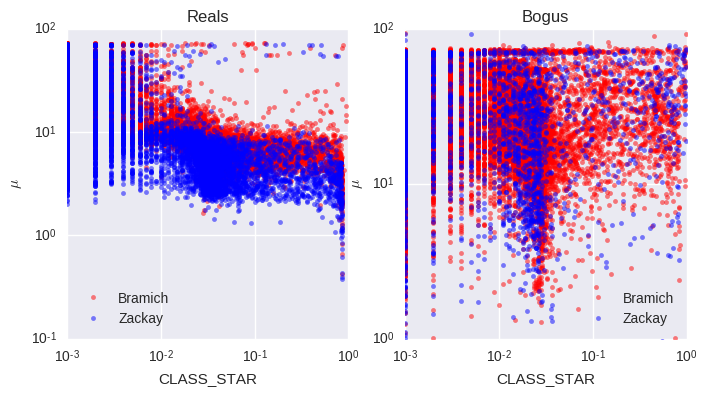

In [45]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.plot(reals_b.CLASS_STAR, reals_b.mu, '.',
            alpha=0.5, color='red', label='Bramich')
plt.plot(reals_z.CLASS_STAR, reals_z.mu, '.', 
            alpha=0.5, color='blue', label='Zackay')

# plt.xlim(0, 16)
# plt.ylim(-0.1, 1.3)
plt.loglog()
plt.xlabel(r'CLASS_STAR')
plt.ylabel(r'$\mu$')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus')
plt.plot(bogus_b.CLASS_STAR, bogus_b.mu, '.',
            alpha=0.5, color='red', label='Bramich')
plt.plot(bogus_z.CLASS_STAR, bogus_z.mu, '.', 
            alpha=0.5, color='blue', label='Zackay')
plt.ylim(1, 100.)
plt.loglog()
plt.xlabel(r'CLASS_STAR')
plt.ylabel(r'$\mu$')
plt.legend(loc='best')


## Simulation parameters

We need data on simulation for every object, specially undetected (there are a lot of these)

In [46]:
sim_pars = pd.read_sql_query("""SELECT * FROM Images""", engine)

Now we will merge our simulation parameters on undetected objects:

In [47]:
und_b = pd.merge(left=und_b, right=sim_pars, left_on='image_id', right_on='id', how='left')
und_z = pd.merge(left=und_z, right=sim_pars, left_on='image_id', right_on='id', how='left')

In [48]:
print ' Columns of sim_pars:\n', sim_pars.columns
print '\n Columns of und_b:\n', und_b.columns
print '\n Columns of und_z:\n', und_z.columns
print '\n Columns of simulated:\n', simulated.columns

 Columns of sim_pars:
Index([u'id', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm'],
      dtype='object')

 Columns of und_b:
Index([u'x', u'y', u'app_mag', u'image_id', u'r_scales', u'gx_mag',
       u'simulated_id', u'id', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm'],
      dtype='object')

 Columns of und_z:
Index([u'x', u'y', u'app_mag', u'image_id', u'r_scales', u'gx_mag',
       u'simulated_id', u'id', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm'],
      dtype='object')

 Columns of simulated:
Index([u'id', u'code', u'x', u'y', u'app_mag', u'r_scales', u'gx_mag',
       u'image_id', u'image_id_ois', u'image_id_hot'],
      dtype='object')


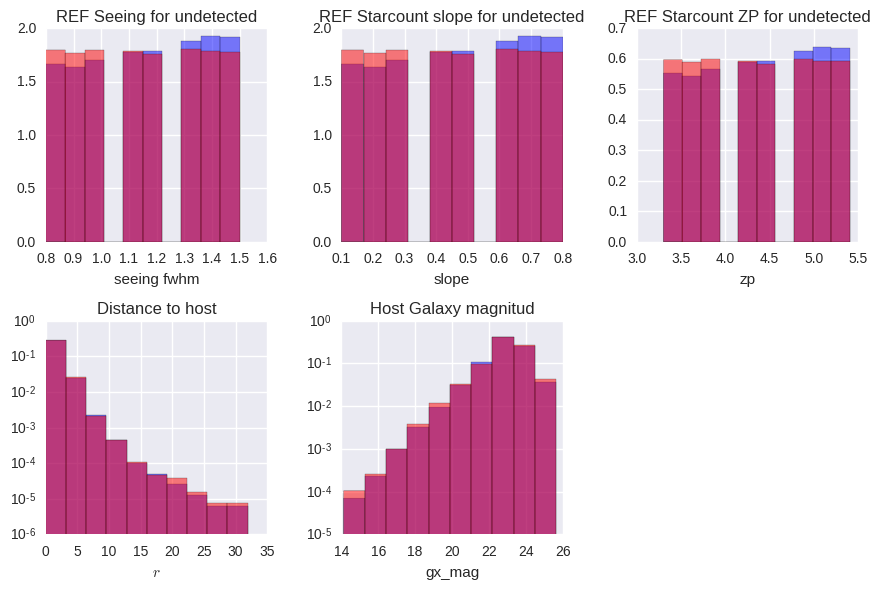

In [49]:
plt.figure(figsize=(9, 6))
plt.subplot(2, 3, 1)
plt.hist(und_z['refseeing_fwhm'], cumulative=False, histtype='bar', alpha=0.5 , color='blue', normed=True)
plt.hist(und_b['refseeing_fwhm'], cumulative=False, histtype='bar', alpha=0.5, color='red', normed=True)
plt.xlabel('seeing fwhm')
plt.title('REF Seeing for undetected')

plt.subplot(2, 3, 2)
plt.hist(und_z['refstarcount_slope'], cumulative=False, histtype='bar', alpha=0.5 , color='blue', normed=True)
plt.hist(und_b['refstarcount_slope'], cumulative=False, histtype='bar', alpha=0.5, color='red', normed=True)
plt.xlabel('slope')
plt.title('REF Starcount slope for undetected')

plt.subplot(2, 3, 3)
plt.hist(np.log10(und_z['refstarcount_zp']), cumulative=False, histtype='bar', 
         alpha=0.5 , color='blue', normed=True)
plt.hist(np.log10(und_b['refstarcount_zp']), cumulative=False, histtype='bar', 
         alpha=0.5, color='red', normed=True)
plt.xlabel('zp')
plt.title('REF Starcount ZP for undetected')

plt.subplot(2, 3, 4)
plt.hist(und_z['r_scales'], cumulative=False, histtype='bar', alpha=0.5, color='blue', log=True, normed=True)
plt.hist(und_b['r_scales'], cumulative=False, histtype='bar', alpha=0.5, color='red', log=True, normed=True)
plt.xlabel(r'$r$')
plt.title('Distance to host')

plt.subplot(2, 3, 5)
plt.hist(und_z['gx_mag'], cumulative=False, histtype='bar', alpha=0.5, color='blue', log=True, normed=True)
plt.hist(und_b['gx_mag'], cumulative=False, histtype='bar', alpha=0.5, color='red', log=True, normed=True)
plt.xlabel(r'gx_mag')
plt.title('Host Galaxy magnitud')


plt.tight_layout()
plt.show()

In [50]:
reals_b = pd.merge(left=reals_b, right=sim_pars, left_on='image_id', right_on='id', how='left')
reals_z = pd.merge(left=reals_z, right=sim_pars, left_on='image_id', right_on='id', how='left')

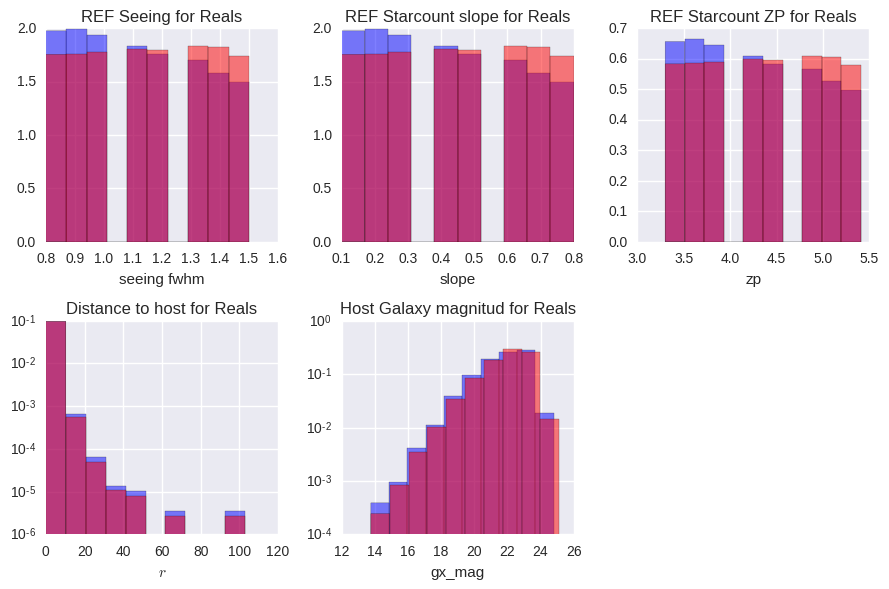

In [54]:
plt.figure(figsize=(9, 6))
plt.subplot(2, 3, 1)
plt.hist(reals_z['refseeing_fwhm'], cumulative=False, histtype='bar',
         alpha=0.5 , color='blue', normed=True)
plt.hist(reals_b['refseeing_fwhm'], cumulative=False, histtype='bar',
         alpha=0.5, color='red', normed=True)
plt.xlabel('seeing fwhm')
plt.title('REF Seeing for Reals')

plt.subplot(2, 3, 2)
plt.hist(reals_z['refstarcount_slope'], cumulative=False, histtype='bar',
         alpha=0.5 , color='blue', normed=True)
plt.hist(reals_b['refstarcount_slope'], cumulative=False, histtype='bar',
         alpha=0.5, color='red', normed=True)
plt.xlabel('slope')
plt.title('REF Starcount slope for Reals')

plt.subplot(2, 3, 3)
plt.hist(np.log10(reals_z['refstarcount_zp']), cumulative=False, histtype='bar', 
         alpha=0.5 , color='blue', normed=True)
plt.hist(np.log10(reals_b['refstarcount_zp']), cumulative=False, histtype='bar', 
         alpha=0.5, color='red', normed=True)
plt.xlabel('zp')
plt.title('REF Starcount ZP for Reals')

plt.subplot(2, 3, 4)
plt.hist(reals_z['r_scales'], cumulative=False, histtype='bar',
         alpha=0.5, color='blue', log=True, normed=True)
plt.hist(reals_b['r_scales'], cumulative=False, histtype='bar',
         alpha=0.5, color='red', log=True, normed=True)
plt.xlabel(r'$r$')
plt.title('Distance to host for Reals')

plt.subplot(2, 3, 5)
plt.hist(reals_z['gx_mag'], cumulative=False, histtype='bar',
         alpha=0.5, color='blue', log=True, normed=True)
plt.hist(reals_b['gx_mag'], cumulative=False, histtype='bar',
         alpha=0.5, color='red', log=True, normed=True)
plt.xlabel(r'gx_mag')
plt.title('Host Galaxy magnitud for Reals')


plt.tight_layout()
plt.show()

In [52]:
print bogus_b.columns
print bogus_z.columns
print sim_pars.columns

Index([           u'id',        u'NUMBER',      u'FLUX_ISO',   u'FLUXERR_ISO',
             u'MAG_ISO',    u'MAGERR_ISO',     u'FLUX_APER',  u'FLUXERR_APER',
            u'MAG_APER',   u'MAGERR_APER',     u'FLUX_AUTO',  u'FLUXERR_AUTO',
            u'MAG_AUTO',   u'MAGERR_AUTO',    u'BACKGROUND',     u'THRESHOLD',
            u'FLUX_MAX',    u'XMIN_IMAGE',    u'YMIN_IMAGE',    u'XMAX_IMAGE',
          u'YMAX_IMAGE',   u'XPEAK_IMAGE',   u'YPEAK_IMAGE',       u'X_IMAGE',
             u'Y_IMAGE',      u'X2_IMAGE',      u'Y2_IMAGE',      u'XY_IMAGE',
           u'CXX_IMAGE',     u'CYY_IMAGE',     u'CXY_IMAGE',       u'A_IMAGE',
             u'B_IMAGE',   u'THETA_IMAGE',        u'MU_MAX',         u'FLAGS',
          u'FWHM_IMAGE',    u'ELONGATION',   u'ELLIPTICITY',    u'CLASS_STAR',
              u'DELTAX',        u'DELTAY',         u'RATIO',     u'ROUNDNESS',
       u'PEAK_CENTROID',       u'IS_REAL',      u'image_id',       u'sim_mag',
              u'sim_id',      u'r_scales',        u'

## Checking on the outliers

In [49]:
from astropy.nddata.utils import extract_array
from astropy.io import fits


def get_patch_bramich(x, y, image_id):
    """Gets data from a row of a table, from a bramich subtracted source, and uses
    its coordinates to extract a patch from the image.
    """
    size = (14, 14)
    
    path = os.path.join('/home/bruno/Data/RBpipeline/images', 
                        'img'+str(image_id).zfill(5))
    filepath = os.path.join(path, 'diff_ois.fits')
    
    pixdata = fits.getdata(filepath)
    
    patch = extract_array(pixdata, size, (x, y))
    
    return patch
    
    
def get_patch_zackay(x, y, image_id):
    """Gets data from a row of a table, from a bramich subtracted source, and uses
    its coordinates to extract a patch from the image.
    """
    size = (14, 14)
    
    path = os.path.join('/home/bruno/Data/RBpipeline/images', 
                        'img'+str(image_id).zfill(5))
    filepath = os.path.join(path, 'diff.fits')
    
    pixdata = fits.getdata(filepath)
    
    patch = extract_array(pixdata, size, (x, y))
    
    return patch
    

In [50]:
outliers_b = bogus_b[bogus_b.CLASS_STAR > .97]

In [51]:
outliers_b

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,DELTAY,RATIO,ROUNDNESS,PEAK_CENTROID,IS_REAL,image_id,sim_mag,sim_id,mag,mu
13945,13946,62,9101.681,158.6912,15.1022,0.0189,2935.942,247.3750,16.3306,0.0915,...,3.0,0.666667,1.093264,0.557934,False,150,NaN,NaN,21.021163,57.355420
81983,81984,182,5671.524,150.6297,15.6158,0.0288,-11547.550,299.1432,99.0000,99.0000,...,2.0,1.000000,1.352657,0.051976,False,785,NaN,NaN,21.534763,92.886313


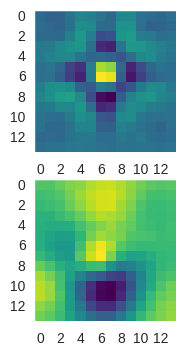

In [52]:
plt.figure(figsize=( 6, 2*len(outliers_b)))
for i in range(len(outliers_b)):
    patch = get_patch_bramich(outliers_b[i:i+1]['Y_IMAGE'], 
                              outliers_b[i:i+1]['X_IMAGE'], 
                              int(outliers_b[i:i+1]['image_id']))
    plt.subplot(len(outliers_b), 1 , i+1)
    plt.grid()
    plt.imshow(patch, cmap='viridis', interpolation='none')

In [53]:
outliers_z = bogus_z[bogus_z.ELONGATION > 8]

In [54]:
outliers_z

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,DELTAY,RATIO,ROUNDNESS,PEAK_CENTROID,IS_REAL,image_id,sim_mag,sim_id,mag,mu
98,99,1,218.67100,5.934724,19.1505,0.0295,20.519460,4.392409,21.7196,0.2325,...,1.0,0.055556,9.074899,2.437797,False,3,NaN,NaN,20.226979,9.133460
6987,6988,41,15.41021,2.221045,22.0305,0.1565,8.515002,4.401931,22.6745,0.5614,...,4.0,0.750000,8.131818,0.169406,False,146,NaN,NaN,23.106979,58.709738
8354,8355,53,21.08393,2.977328,21.6901,0.1534,-63.586320,4.407161,99.0000,99.0000,...,0.0,0.000000,8.193772,2.220700,False,175,NaN,NaN,22.766579,33.267352
14549,14550,49,45.84899,3.110233,20.8467,0.0737,-15.320310,4.367636,99.0000,99.0000,...,0.0,0.000000,9.463668,0.378300,False,307,NaN,NaN,21.923179,27.736289
15555,15556,3,79.61983,4.078629,20.2474,0.0556,-69.636300,4.392817,99.0000,99.0000,...,2.0,0.153846,13.020761,1.452900,False,331,NaN,NaN,21.323879,19.608038
15869,15870,12,30.56903,2.964957,21.2868,0.1053,5.175158,4.357579,23.2152,0.9144,...,7.0,0.142857,8.616541,0.348456,False,338,NaN,NaN,22.363279,36.680836
15983,15984,2,108.24030,4.616012,19.9140,0.0463,18.016910,4.348059,21.8608,0.2621,...,4.0,0.307692,9.524242,4.544290,False,341,NaN,NaN,20.990479,20.237834
16618,16619,27,93.76862,3.946635,20.0699,0.0457,-1.850126,4.372580,99.0000,99.0000,...,13.0,0.153846,10.536810,2.353318,False,355,NaN,NaN,21.146379,18.883899
19909,19910,37,75.81461,3.690353,20.3006,0.0529,12.727690,4.357564,22.2381,0.3718,...,1.0,0.090909,11.525362,2.067764,False,426,NaN,NaN,21.377079,24.348690
19918,19919,46,174.80970,5.579289,19.3936,0.0347,31.581520,4.379831,21.2514,0.1506,...,2.0,0.100000,8.141831,2.545000,False,426,NaN,NaN,20.470079,8.103769


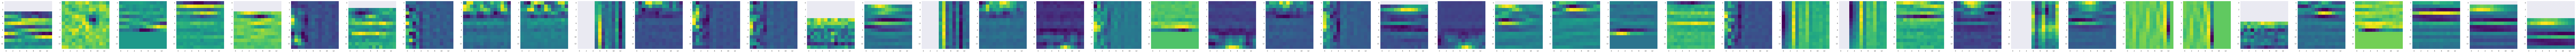

In [55]:
plt.figure(figsize=(6*len(outliers_z), 12))
for i in range(len(outliers_z)):
    patch = get_patch_zackay(outliers_z[i:i+1]['Y_IMAGE'], 
                              outliers_z[i:i+1]['X_IMAGE'], 
                              int(outliers_z[i:i+1]['image_id']))
    plt.subplot(1, len(outliers_z), i+1)
    plt.grid()
    plt.imshow(patch, cmap='viridis', interpolation='none')